# Basic set up

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import warnings
import joblib
import tqdm

from joblib import parallel_backend

import sklearn.metrics as skm

from sklearn.model_selection import ParameterGrid
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
seed = 11

In [4]:
df_train = pd.read_csv("../data/processed/train_data.csv", index_col = 0)
df_val = pd.read_csv("../data/processed/validation_data.csv", index_col = 0)

# Classes 

## Data Prep Classs

In [110]:
class PrepDataset():

    def __init__(
            self, df : pd.DataFrame, df_name : str, ohe_cutoff : int = 20, outliers : str = None, 
            target : str = "isFraud", imbalance : str = None, seed : int = 11, normalize : str = None,
            sampling_strategy : float = 0.5, 
            cols_to_remove : list = ["step", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]):
        
        valid_names = ["train", "validation", "test"]

        if df_name not in valid_names:
            raise ValueError(f"invalid df_name : {df_name}, use one of {valid_names}")
        
        self.df_name = df_name

        self.df = df.copy()
        self.df_orginal = df.copy()

        self.remove_columns(col_list = cols_to_remove)

        self.encode_categoriacals(ohe_cutoff = ohe_cutoff)

        if outliers:
            self.replace_outliers(method = outliers, df_name = df_name)

        self.x, self.y = None, None
        self.split_x_y(target = target)

        if imbalance and df_name == "train":
            self.resampling(method = imbalance, sampling_strategy = sampling_strategy)

        if normalize:
            self.normalize_dataset(df_name = df_name, method = normalize)
    
    def remove_columns(self, col_list : list):
        """
        This function drops a list of columns from 
        the dataframe.
        """

        self.df.drop(col_list, axis = 1, inplace = True)
    
    def encode_categoriacals(self, ohe_cutoff : int = 20, mappings_save_path : str = "../data/other/"):
        """
        This function encodes the categorical columns so they can be feed into 
        a model. The parameter ohe_cutoff divides the columns into two lists. The 
        first list, containing less unique values per column than then the parameter, will store 
        the column names that will be one hot encoded. The second list, conataining more or 
        equal unique values per column than the parameter, will store the column names that will
        be label encoded.
        """
        mappings_save_path += f"mappings_label_encoding_{self.df_name}.json"

        df_unq_vals = self.df.select_dtypes(include = "object").nunique().reset_index().rename({"index" : "col_name", 0 : "n_unique_values"}, axis = 1)
        ohe_list = df_unq_vals.loc[df_unq_vals.n_unique_values < ohe_cutoff, "col_name"].tolist()
        label_enc_list = df_unq_vals.loc[df_unq_vals.n_unique_values >= ohe_cutoff, "col_name"].tolist()

        # one hot encoding 
        self.df = pd.get_dummies(data = self.df, columns = ohe_list, dtype = int)
        
        # label encoding
        mappings_label_encoding = {}

        for col in label_enc_list:
            self.df[col] = self.df[col].astype("category")
            mappings_label_encoding[col] = dict(enumerate(self.df[col].cat.categories))

            self.df[col] = self.df[col].cat.codes

        with open(mappings_save_path, 'w') as f:
            json.dump(mappings_label_encoding, f)
    
    def restore_data(self):
        """
        This function restores the data to the original version before
        replacing outliers.
        """

        self.df = self.original_df.copy()
    
    def replace_outliers(self, method : str = "z_score", df_name : str = "train"):
        """
        This function substitutes outliers with the border value 
        according to which method chosen.
        """
        
        valid_methods = ["z_score", "iqr", "both"]

        if method not in valid_methods:
            raise ValueError(f"invalid method : {method}, use one of {valid_methods}")
        
        
        bounds_json = "../data/other/outliers_bounds.json"

        if not os.path.exists(bounds_json):
            outlier_bounds = {}
        else:
            with open(bounds_json, "r") as file:
                outlier_bounds = json.load(file)
        
        
        col_outliers = self.df.select_dtypes(include = "float").columns.tolist()

        for col in col_outliers:

            if df_name == "train":
                mean = self.df[col].mean()
                std = self.df[col].std()

                self.df["z_score"] = (self.df[col] - mean) / std
                zscore_upper_bound = self.df[self.df.z_score <= 3].sort_values(by = col, ascending = False)[col].head(1).values[0]
                zscore_lower_bound = self.df[self.df.z_score >= -3].sort_values(by = col)[col].head(1).values[0]
                self.df.drop("z_score", axis = 1, inplace = True)

                q1 = self.df[col].quantile(0.25)
                q3 = self.df[col].quantile(0.75)
                iqr = q3 - q1 

                iqr_upper_bound = q3 + 1.5 * iqr
                iqr_lower_bound = q1 - 1.5 * iqr

                outlier_bounds[col] = {
                "z_upper": zscore_upper_bound, "z_lower": zscore_lower_bound,
                "iqr_upper": iqr_upper_bound, "iqr_lower": iqr_lower_bound
                }

                with open(bounds_json, "w") as file:
                    json.dump(outlier_bounds, file, indent=4)

            else:
                bounds = outlier_bounds.get(col)

                if bounds is None:
                    raise ValueError(f"No stored bounds for column {col}.")
                
                zscore_upper_bound = bounds["z_upper"]
                zscore_lower_bound = bounds["z_lower"]
                iqr_upper_bound = bounds["iqr_upper"]
                iqr_lower_bound = bounds["iqr_lower"]

            if method == "both":
                upper_bound  = min(zscore_upper_bound, iqr_upper_bound)
                lower_bound = max(zscore_lower_bound, iqr_lower_bound)
            
            elif method == "z_score":
                upper_bound  = zscore_upper_bound
                lower_bound = zscore_lower_bound
            
            elif method == "iqr":
                upper_bound  = iqr_upper_bound
                lower_bound = iqr_lower_bound
        
            if len(self.df[self.df[col] > upper_bound]) > 0:
                    self.df.loc[self.df[col] > upper_bound, col] = upper_bound
                
            if len(self.df[self.df[col] < lower_bound]) > 0:
                self.df.loc[self.df[col] < lower_bound, col] = lower_bound
    
    def split_x_y(self, target : str) -> tuple[pd.DataFrame, pd.Series]:
        """
        This function splits a dataframe in x (the dataframe containing the predictors) and
        y (the series witht the target)
        """

        predictors = self.df.columns.tolist()
        predictors.remove(target)

        self.x = self.df[predictors]
        self.y = self.df[target]
    
    def resampling(self, method : str = "smote", sampling_strategy : float = 0.05):
        """
        This function resamples the dataset based on the strategy chosen via the 
        method parameter 
        """
        valid_methods = ["smote", "tomek", "both"]

        if method not in valid_methods:
            raise ValueError(f"invalid method : {method}, use one of {valid_methods}")
        
        if method == "smote":
            resampler = SMOTE(sampling_strategy = sampling_strategy, random_state = seed)
        
        elif method == "tomek":
            resampler = TomekLinks(sampling_strategy = "auto")
        
        elif method == "both":
            resampler = SMOTETomek(random_state = seed, sampling_strategy = sampling_strategy)
        
        self.x, self.y = resampler.fit_resample(self.x, self.y)

    def normalize_dataset(self, df_name : str, method : str = "standard"):
        """
        This function normalizes the dataset.
        """

        valid_methods = ["standard", "min_max"]

        if method not in valid_methods:
            raise ValueError(f"invalid method : {method}, use one of {valid_methods}")
        
        if df_name == "train":

            if method == "standard":
                scaler = StandardScaler()
            
            elif method == "min_max":
                scaler = MinMaxScaler(feature_range = (0, 1))
            
            self.x = scaler.fit_transform(self.x)
            self.x = pd.DataFrame(self.x, columns = scaler.feature_names_in_)

            joblib.dump(scaler, f"../models/scalers/{method}_scaler.pkl")
        
        else:
            scaler_path = f"../models/scalers/{method}_scaler.pkl"

            if not os.path.exists(scaler_path):
                raise FileNotFoundError(f"No scaler found at {scaler_path}. Normalize training data first.")
            
            else:
                scaler = joblib.load(scaler_path)

            self.x = scaler.transform(self.x)
            self.x = pd.DataFrame(self.x, columns = scaler.feature_names_in_)

    def return_x_y(self) -> tuple[pd.DataFrame, pd.Series]:
        """
        This function returns the dataframe.
        """  

        return self.x, self.y

## Classical Models Evaluation Class

In [152]:
class ClassicModelsEvaluation():

    def __init__(
            self, x_train : pd.DataFrame, y_train : pd.Series, x_val : pd.DataFrame, y_val : pd.Series, 
            df_eval : pd.DataFrame, imbalance : str, outliers : str, normalize : str, model, 
            model_name : str, compute_cm : bool = False):
        
        if not outliers:
                outliers = "none"
        if not imbalance:
            imbalance = "none"
        if not normalize:
            normalize = "none"
        
        self.x_train =  x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val

        self.df_eval = df_eval

        self.imbalance = imbalance
        self.outliers = outliers
        self.normalize = normalize

        self.compute_cm = compute_cm
        self.confusion_matrix = None

        with parallel_backend("threading"):
            self.evaluate_model(model = model, model_name = model_name, compute_cm = self.compute_cm)
        
    def evaluate_model(self, model, model_name : str, compute_cm : bool):
        """
        This function first trains the model on the training data contained in the class, and 
        then evaluates it using both the training data and the validation data, also present in the
        class. The results are then stored in the df_eval.
        """

        # training the model
        model.fit(self.x_train, self.y_train)

        # computing predictions
        y_pred_train = model.predict(self.x_train)
        y_pred_val = model.predict(self.x_val)
        
        # calculating metrics
        accuracy_train = skm.accuracy_score(y_pred = y_pred_train, y_true = self.y_train)
        recall_train = skm.recall_score(y_pred = y_pred_train, y_true = self.y_train, zero_division=0)
        precision_train = skm.precision_score(y_pred = y_pred_train, y_true = self.y_train, zero_division=0)
        f1_score_train = skm.f1_score(y_pred = y_pred_train, y_true = self.y_train, zero_division=0)

        accuracy_val = skm.accuracy_score(y_pred = y_pred_val, y_true = self.y_val)
        recall_val = skm.recall_score(y_pred = y_pred_val, y_true = self.y_val, zero_division=0)
        precision_val = skm.precision_score(y_pred = y_pred_val, y_true = self.y_val, zero_division=0)
        f1_score_val = skm.f1_score(y_pred = y_pred_val, y_true = self.y_val, zero_division=0)

        # saving results
        self.df_eval.loc[len(self.df_eval)] = {
            "normalization" : self.normalize,
            "imbalance" : self.imbalance,
            "outliers" : self.outliers,
            "model" : model_name, 
            "dataset" : "train", 
            "accuracy" : accuracy_train,
            "recall" : recall_train, 
            "precision" : precision_train, 
            "f1_score" : f1_score_train}

        self.df_eval.loc[len(self.df_eval)] = {
            "normalization" : self.normalize,
            "imbalance" : self.imbalance,
            "outliers" : self.outliers,
            "model" : model_name, 
            "dataset" : "validation", 
            "accuracy" : accuracy_val,
            "recall" : recall_val, 
            "precision" : precision_val, 
            "f1_score" : f1_score_val}
        
        if compute_cm:
            self.confusion_matrix = skm.confusion_matrix(y_pred = y_pred_val, y_true = self.y_val)

    def plot_confusion_matrix(self):
        if not self.compute_cm:
            raise ValueError("compute_cm parameter has to be true to use this function")
        
        cm_disp = skm.ConfusionMatrixDisplay(confusion_matrix = self.confusion_matrix)

        cm_disp.plot(values_format = 'd')
        plt.show()
        
    def return_df_eval(self):
        """
        This function retuns the df eval.
        """

        return self.df_eval

# Modeling

## Classical Models

### Model Selection

We run an evaluation for all the classical models chosen to get an idea of which might perform better. This allows us to focus on a single model for further analysis.

We will run the analysis without treating the outliers or the imblance as those will be explored further, however the data will be normalized or not based on the model 

In [155]:
df_eval_models = pd.DataFrame(columns = ["normalization","imbalance", "outliers", "model", "dataset", "accuracy", "recall", "precision", "f1_score"])
df_eval_models

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score


In [156]:
outliers = None
imbalance = None

#### Logistic Regression

In [157]:
normalize = "standard"

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4453834, 9), (4453834,), (1272524, 9), (1272524,))

In [158]:
log_ref_class = LogisticRegression(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_models,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = log_ref_class,
    model_name = "logistic regression",
    compute_cm = True
)

In [159]:
df_eval_models

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,standard,none,none,logistic regression,train,0.998699,0.001913,0.161765,0.003782
1,standard,none,none,logistic regression,validation,0.998702,0.003043,0.263158,0.006017


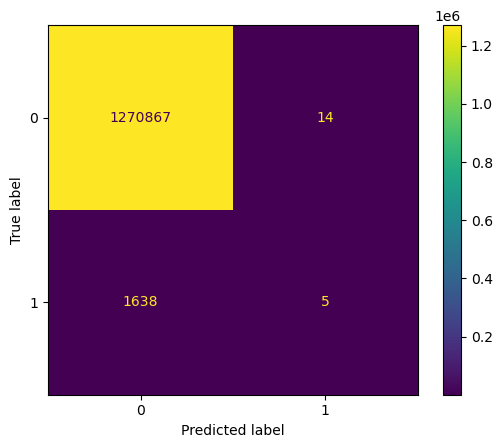

In [160]:
c_model_eval.plot_confusion_matrix()

#### Random Forest

In [161]:
normalize = None

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4453834, 9), (4453834,), (1272524, 9), (1272524,))

In [162]:
rf_class = RandomForestClassifier(n_jobs = - 1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_models,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = rf_class,
    model_name = "random forest",
    compute_cm = True
)

In [163]:
df_eval_models

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,standard,none,none,logistic regression,train,0.998699,0.001913,0.161765,0.003782
1,standard,none,none,logistic regression,validation,0.998702,0.003043,0.263158,0.006017
2,none,none,none,random forest,train,0.999997,0.997391,1.000000,0.998694
3,none,none,none,random forest,validation,0.998853,0.157638,0.773134,0.261881


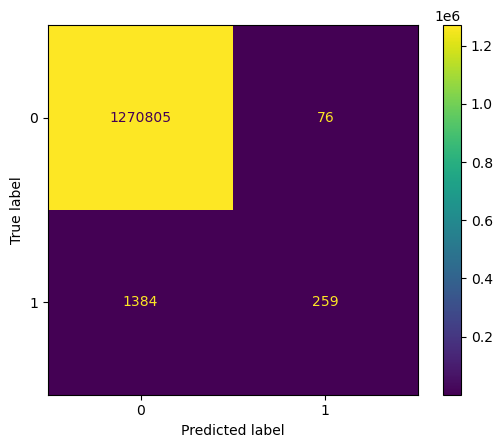

In [164]:
c_model_eval.plot_confusion_matrix()

#### XGB

In [165]:
normalize = None

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4453834, 9), (4453834,), (1272524, 9), (1272524,))

In [166]:
xgb_class = XGBClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_models,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = xgb_class,
    model_name = "xgb",
    compute_cm = True
)

In [167]:
df_eval_models

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,standard,none,none,logistic regression,train,0.998699,0.001913,0.161765,0.003782
1,standard,none,none,logistic regression,validation,0.998702,0.003043,0.263158,0.006017
2,none,none,none,random forest,train,0.999997,0.997391,1.000000,0.998694
3,none,none,none,random forest,validation,0.998853,0.157638,0.773134,0.261881
4,none,none,none,xgb,train,0.998775,0.103322,0.665174,0.178862
5,none,none,none,xgb,validation,0.998744,0.090079,0.589641,0.156283


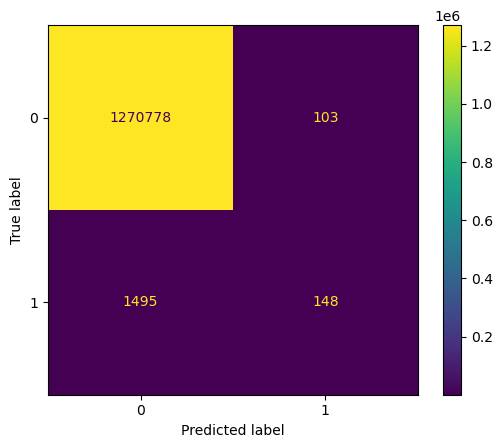

In [168]:
c_model_eval.plot_confusion_matrix()

#### LGBM

In [169]:
normalize = None

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4453834, 9), (4453834,), (1272524, 9), (1272524,))

In [170]:
lgbm_class = LGBMClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_models,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm",
    compute_cm = True
)

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203


In [171]:
df_eval_models

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,standard,none,none,logistic regression,train,0.998699,0.001913,0.161765,0.003782
1,standard,none,none,logistic regression,validation,0.998702,0.003043,0.263158,0.006017
2,none,none,none,random forest,train,0.999997,0.997391,1.000000,0.998694
3,none,none,none,random forest,validation,0.998853,0.157638,0.773134,0.261881
4,none,none,none,xgb,train,0.998775,0.103322,0.665174,0.178862
5,none,none,none,xgb,validation,0.998744,0.090079,0.589641,0.156283
6,none,none,none,lgbm,train,0.998846,0.139503,0.805221,0.237806
7,none,none,none,lgbm,validation,0.998788,0.111382,0.690566,0.191824


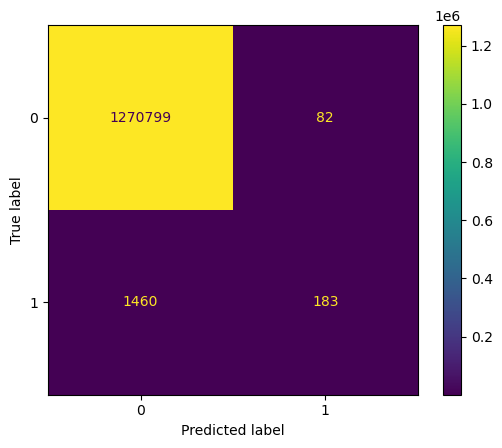

In [172]:
c_model_eval.plot_confusion_matrix()

#### Evalatuion of Results 

In [176]:
df_eval_models

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,standard,none,none,logistic regression,train,0.998699,0.001913,0.161765,0.003782
1,standard,none,none,logistic regression,validation,0.998702,0.003043,0.263158,0.006017
2,none,none,none,random forest,train,0.999997,0.997391,1.000000,0.998694
3,none,none,none,random forest,validation,0.998853,0.157638,0.773134,0.261881
4,none,none,none,xgb,train,0.998775,0.103322,0.665174,0.178862
5,none,none,none,xgb,validation,0.998744,0.090079,0.589641,0.156283
6,none,none,none,lgbm,train,0.998846,0.139503,0.805221,0.237806
7,none,none,none,lgbm,validation,0.998788,0.111382,0.690566,0.191824


We will continue using lgbm as a model, since outside of random forest offers the best perfomance. The random forest model it is not selected for two reasons, first condisdering that the train dataset is more tha 4 million rows the model is very slow to train rendering it very impractical for later stages where it will be required to train the selected model several times. Second random forest is showing significant overfitting, which of course can be mitigated but at this stage it seems better to choose a model less prone to overfitting and working on improving its perfomance rather than dealing with the random forest models overfitting.

### Outliers

In this section we will try to handle the outliers to see if we can improve the models perfomance

In [177]:
df_eval_outliers = pd.DataFrame(columns = ["normalization","imbalance", "outliers", "model", "dataset", "accuracy", "recall", "precision", "f1_score"])
df_eval_outliers

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score


In [178]:
normalize = None
imbalance = None

#### No method 
we use this result as a baseline 

In [179]:
outliers = None

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4453834, 9), (4453834,), (1272524, 9), (1272524,))

In [180]:
lgbm_class = LGBMClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_outliers,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm",
    compute_cm = True
)

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203


In [181]:
df_eval_outliers

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,none,lgbm,train,0.998846,0.139503,0.805221,0.237806
1,none,none,none,lgbm,validation,0.998788,0.111382,0.690566,0.191824


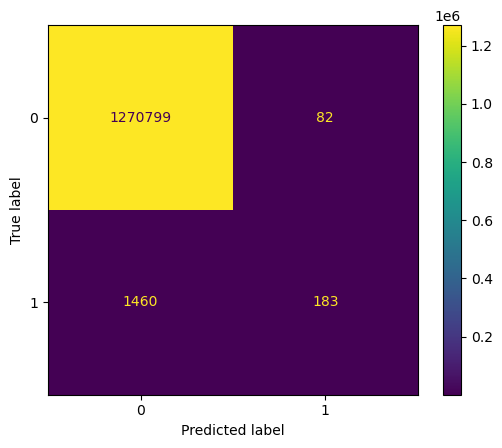

In [182]:
c_model_eval.plot_confusion_matrix()

#### Z score

In [183]:
outliers = "z_score"

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4453834, 9), (4453834,), (1272524, 9), (1272524,))

In [184]:
lgbm_class = LGBMClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_outliers,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm",
    compute_cm = True
)

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203


In [185]:
df_eval_outliers

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,none,lgbm,train,0.998846,0.139503,0.805221,0.237806
1,none,none,none,lgbm,validation,0.998788,0.111382,0.690566,0.191824
2,none,none,z_score,lgbm,train,0.998862,0.160550,0.792955,0.267033
3,none,none,z_score,lgbm,validation,0.998835,0.156421,0.725989,0.257386


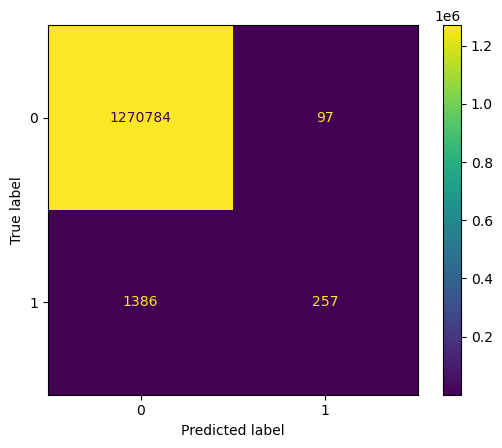

In [186]:
c_model_eval.plot_confusion_matrix()

#### IQR 

In [187]:
outliers = "iqr"

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4453834, 9), (4453834,), (1272524, 9), (1272524,))

In [188]:
lgbm_class = LGBMClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_outliers,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm",
    compute_cm = True
)

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203


In [189]:
df_eval_outliers

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,none,lgbm,train,0.998846,0.139503,0.805221,0.237806
1,none,none,none,lgbm,validation,0.998788,0.111382,0.690566,0.191824
2,none,none,z_score,lgbm,train,0.998862,0.160550,0.792955,0.267033
3,none,none,z_score,lgbm,validation,0.998835,0.156421,0.725989,0.257386
4,none,none,iqr,lgbm,train,0.998691,0.013568,0.327731,0.026056
5,none,none,iqr,lgbm,validation,0.997969,0.001217,0.002116,0.001546


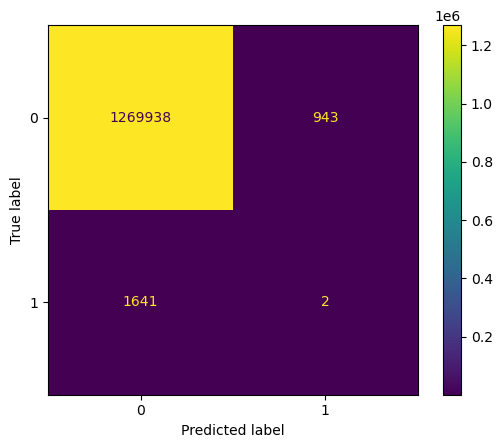

In [190]:
c_model_eval.plot_confusion_matrix()

#### Both

In [191]:
outliers = "both"

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4453834, 9), (4453834,), (1272524, 9), (1272524,))

In [192]:
lgbm_class = LGBMClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_outliers,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm",
    compute_cm = True
)

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203


In [193]:
df_eval_outliers

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,none,lgbm,train,0.998846,0.139503,0.805221,0.237806
1,none,none,none,lgbm,validation,0.998788,0.111382,0.690566,0.191824
2,none,none,z_score,lgbm,train,0.998862,0.160550,0.792955,0.267033
3,none,none,z_score,lgbm,validation,0.998835,0.156421,0.725989,0.257386
4,none,none,iqr,lgbm,train,0.998691,0.013568,0.327731,0.026056
5,none,none,iqr,lgbm,validation,0.997969,0.001217,0.002116,0.001546
6,none,none,both,lgbm,train,0.998691,0.013568,0.327731,0.026056
7,none,none,both,lgbm,validation,0.997969,0.001217,0.002116,0.001546


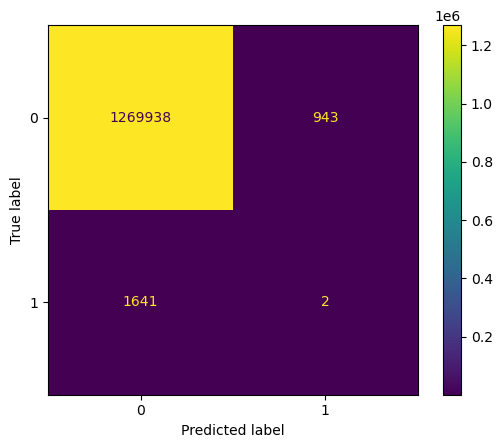

In [194]:
c_model_eval.plot_confusion_matrix()

#### Evaluation of results

In [195]:
df_eval_outliers

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,none,lgbm,train,0.998846,0.139503,0.805221,0.237806
1,none,none,none,lgbm,validation,0.998788,0.111382,0.690566,0.191824
2,none,none,z_score,lgbm,train,0.998862,0.160550,0.792955,0.267033
3,none,none,z_score,lgbm,validation,0.998835,0.156421,0.725989,0.257386
4,none,none,iqr,lgbm,train,0.998691,0.013568,0.327731,0.026056
5,none,none,iqr,lgbm,validation,0.997969,0.001217,0.002116,0.001546
6,none,none,both,lgbm,train,0.998691,0.013568,0.327731,0.026056
7,none,none,both,lgbm,validation,0.997969,0.001217,0.002116,0.001546


From these result its seems the using z score to deal with outliers is the obvious choice since it imporved perfomance on both train and validation datasets, and it reduced the gap between the two. Other than providing the best results.

### Imbalance handling

In [281]:
df_eval_imbalance = pd.DataFrame(columns = ["normalization","imbalance", "outliers", "model", "dataset", "accuracy", "recall", "precision", "f1_score"])
df_eval_imbalance

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score


In [282]:
# Original Imbalance
df_train.isFraud.sum() / len(df_train) * 100

0.1290797995614565

In [283]:
normalize = None
outliers = "z_score"
sampling_strategy = 0.01

#### No method

This result will be used as a baseline

In [284]:
imbalance = None

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4453834, 9), (4453834,), (1272524, 9), (1272524,))

In [285]:
lgbm_class = LGBMClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_imbalance,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm",
    compute_cm = True
)

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651203
[LightGBM] [Info] Start training from score -6.651203


In [286]:
df_eval_imbalance

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,z_score,lgbm,train,0.998862,0.160550,0.792955,0.267033
1,none,none,z_score,lgbm,validation,0.998835,0.156421,0.725989,0.257386


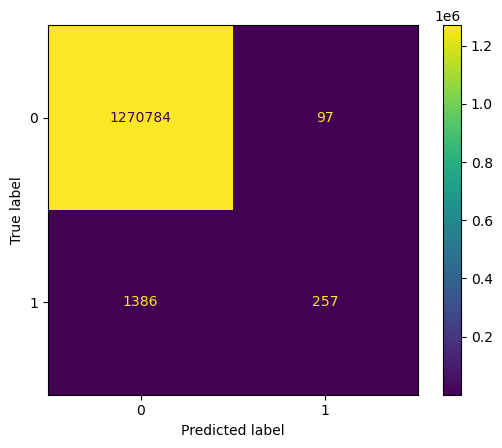

In [287]:
c_model_eval.plot_confusion_matrix()

#### SMOTE

In [288]:
imbalance = "smote"

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize,
    sampling_strategy = sampling_strategy
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4492565, 9), (4492565,), (1272524, 9), (1272524,))

In [289]:
lgbm_class = LGBMClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_imbalance,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm",
    compute_cm = True
)

[LightGBM] [Info] Number of positive: 44480, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 4492565, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009901 -> initscore=-4.605189
[LightGBM] [Info] Start training from score -4.605189


In [290]:
df_eval_imbalance

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,z_score,lgbm,train,0.998862,0.160550,0.792955,0.267033
1,none,none,z_score,lgbm,validation,0.998835,0.156421,0.725989,0.257386
2,none,smote,z_score,lgbm,train,0.995328,0.547999,0.965041,0.699045
3,none,smote,z_score,lgbm,validation,0.998730,0.166159,0.526012,0.252544


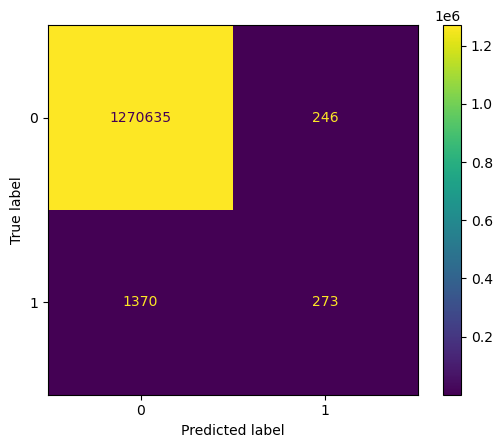

In [291]:
c_model_eval.plot_confusion_matrix()

#### Tomek

In [292]:
imbalance = "tomek"

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4450442, 9), (4450442,), (1272524, 9), (1272524,))

In [293]:
lgbm_class = LGBMClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_imbalance,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm",
    compute_cm = True
)

[LightGBM] [Info] Number of positive: 5749, number of negative: 4444693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 4450442, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650440
[LightGBM] [Info] Start training from score -6.650440


In [294]:
df_eval_imbalance

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,z_score,lgbm,train,0.998862,0.160550,0.792955,0.267033
1,none,none,z_score,lgbm,validation,0.998835,0.156421,0.725989,0.257386
2,none,smote,z_score,lgbm,train,0.995328,0.547999,0.965041,0.699045
3,none,smote,z_score,lgbm,validation,0.998730,0.166159,0.526012,0.252544
4,none,tomek,z_score,lgbm,train,0.998863,0.162811,0.792549,0.270130
5,none,tomek,z_score,lgbm,validation,0.998795,0.149726,0.643979,0.242963


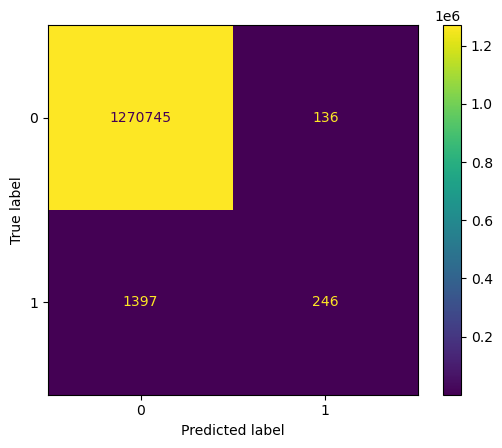

In [295]:
c_model_eval.plot_confusion_matrix()

#### SMOTE & tomek

In [296]:
imbalance = "both"

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize,
    sampling_strategy = sampling_strategy
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4467097, 9), (4467097,), (1272524, 9), (1272524,))

In [297]:
lgbm_class = LGBMClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_imbalance,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm",
    compute_cm = True
)

[LightGBM] [Info] Number of positive: 31746, number of negative: 4435351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 4467097, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007107 -> initscore=-4.939595
[LightGBM] [Info] Start training from score -4.939595


In [298]:
df_eval_imbalance

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,z_score,lgbm,train,0.998862,0.160550,0.792955,0.267033
1,none,none,z_score,lgbm,validation,0.998835,0.156421,0.725989,0.257386
2,none,smote,z_score,lgbm,train,0.995328,0.547999,0.965041,0.699045
3,none,smote,z_score,lgbm,validation,0.998730,0.166159,0.526012,0.252544
4,none,tomek,z_score,lgbm,train,0.998863,0.162811,0.792549,0.270130
5,none,tomek,z_score,lgbm,validation,0.998795,0.149726,0.643979,0.242963
6,none,both,z_score,lgbm,train,0.996570,0.551030,0.942409,0.695436
7,none,both,z_score,lgbm,validation,0.857013,0.154595,0.001405,0.002784


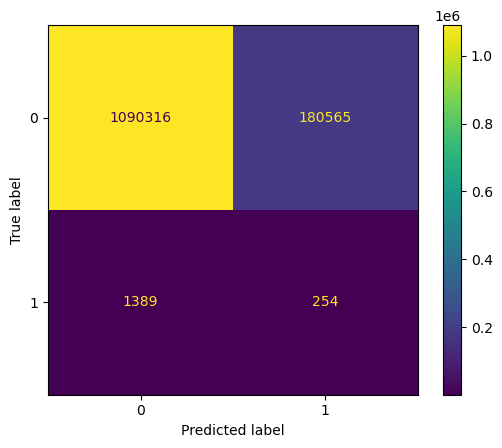

In [299]:
c_model_eval.plot_confusion_matrix()

#### Results Evaluation

In [374]:
df_eval_imbalance

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,z_score,lgbm,train,0.998862,0.160550,0.792955,0.267033
1,none,none,z_score,lgbm,validation,0.998835,0.156421,0.725989,0.257386
2,none,smote,z_score,lgbm,train,0.995328,0.547999,0.965041,0.699045
3,none,smote,z_score,lgbm,validation,0.998730,0.166159,0.526012,0.252544
4,none,tomek,z_score,lgbm,train,0.998863,0.162811,0.792549,0.270130
5,none,tomek,z_score,lgbm,validation,0.998795,0.149726,0.643979,0.242963
6,none,both,z_score,lgbm,train,0.996570,0.551030,0.942409,0.695436
7,none,both,z_score,lgbm,validation,0.857013,0.154595,0.001405,0.002784


From the results its seems its best to not treat the imbalance, we will however keep using boht the non treated method and smote to see if with hyper parater tuning the smote dataset might perform better.

### Model Tuning 

In [389]:
df_eval_tuning = pd.DataFrame(columns = ["normalization","imbalance", "outliers", "model", "dataset", "accuracy", "recall", "precision", "f1_score"])
df_eval_tuning

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score


In [390]:
normalize = None
outliers = "z_score"

#### Imbalance None

In [391]:
imbalance = None

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4453834, 9), (4453834,), (1272524, 9), (1272524,))

##### Baseline Model

In [392]:
lgbm_class = LGBMClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_tuning,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm_baseline",
    compute_cm = True
)

In [393]:
df_eval_tuning

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,z_score,lgbm_baseline,train,0.998862,0.160550,0.792955,0.267033
1,none,none,z_score,lgbm_baseline,validation,0.998835,0.156421,0.725989,0.257386


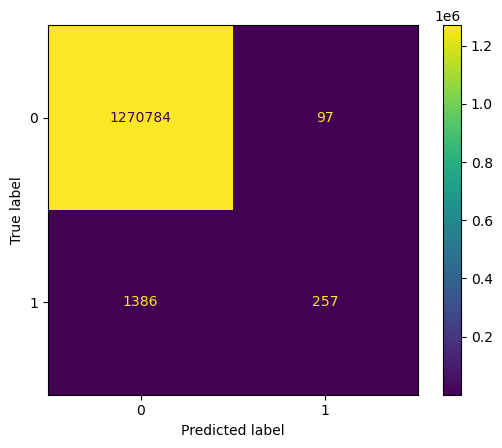

In [394]:
c_model_eval.plot_confusion_matrix()

##### Tuned Model

In [395]:
compute = False # 52 min to compute
nosmote_tuning_json = "../data/evaluation/tuning_nosmote.json"

if compute:
    params_grid = {
        "verbose" : [-1],
        "n_jobs" : [-1],
        "n_estimators" : [100, 1000],
        "random_state" : [seed],
        "max_depth" : [7, -1],
        "num_leaves" : [15, 31],
        "learning_rate" : [0.01, 0.005, 0.1],
        "min_child_samples" : [10, 20],
        "subsample" : [0.8, 1],
        "colsample_bytree" : [0.8, 1],
        "scale_pos_weight" : [1, 30, 300]
    }

    best = {"f1": 0}


    for idx, params in enumerate(ParameterGrid(params_grid)):
        print(idx, " out of", len(ParameterGrid(params_grid)) - 1)

        lgbm_class = LGBMClassifier(**params)

        lgbm_class.fit(x_train, y_train, eval_set=[(x_val, y_val)], callbacks = [early_stopping(stopping_rounds=50)])

        y_pred = lgbm_class.predict(x_val)

        f1_curr = skm.f1_score(y_val, y_pred, zero_division=0)

        if f1_curr > best["f1"]:
            best.update(params)
            best.update({"f1": f1_curr})

    with open(nosmote_tuning_json, "w") as file:
        json.dump(best, file, indent = 4)

else:
    with open(nosmote_tuning_json, "r") as file:
        best = json.load(file)

In [396]:
best

{'f1': 0.2773455377574371,
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 10,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'random_state': 11,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'verbose': -1}

In [397]:
best_params = best.copy()
best_params.pop("f1")
best_params

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 10,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'random_state': 11,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'verbose': -1}

In [398]:
lgbm_class = LGBMClassifier(**best_params)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_tuning,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm_tuned",
    compute_cm = True
)

In [399]:
df_eval_tuning

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,z_score,lgbm_baseline,train,0.998862,0.160550,0.792955,0.267033
1,none,none,z_score,lgbm_baseline,validation,0.998835,0.156421,0.725989,0.257386
2,none,none,z_score,lgbm_tuned,train,0.998847,0.162985,0.742472,0.267294
3,none,none,z_score,lgbm_tuned,validation,0.998809,0.116859,0.747082,0.202105


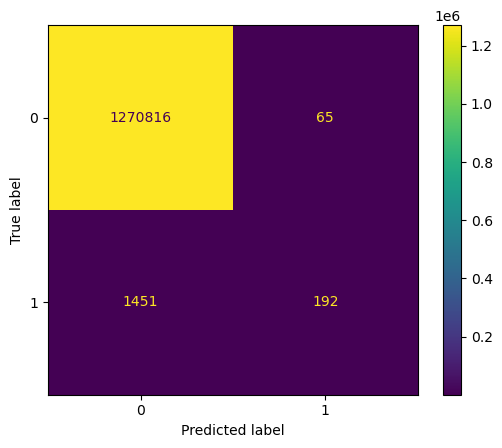

In [400]:
c_model_eval.plot_confusion_matrix()

#### Imbalance SMOTE

In [401]:
imbalance = "smote"
sampling_strategy = 0.01

data_prep_train = PrepDataset(
    df = df_train, 
    df_name = "train", 
    outliers = outliers,
    imbalance = imbalance,
    normalize = normalize,
    sampling_strategy = sampling_strategy
    )

x_train, y_train = data_prep_train.return_x_y()

data_prep_val = PrepDataset(
    df = df_val, 
    df_name = "validation", 
    outliers= outliers, 
    imbalance = imbalance,
    normalize = normalize)

x_val, y_val = data_prep_val.return_x_y()

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4492565, 9), (4492565,), (1272524, 9), (1272524,))

##### Baseline Model

In [402]:
lgbm_class = LGBMClassifier(n_jobs = -1, random_state = seed)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_tuning,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm_baseline",
    compute_cm = True
)

In [403]:
df_eval_tuning

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,z_score,lgbm_baseline,train,0.998862,0.160550,0.792955,0.267033
1,none,none,z_score,lgbm_baseline,validation,0.998835,0.156421,0.725989,0.257386
2,none,none,z_score,lgbm_tuned,train,0.998847,0.162985,0.742472,0.267294
3,none,none,z_score,lgbm_tuned,validation,0.998809,0.116859,0.747082,0.202105
4,none,smote,z_score,lgbm_baseline,train,0.995328,0.547999,0.965041,0.699045
5,none,smote,z_score,lgbm_baseline,validation,0.998730,0.166159,0.526012,0.252544


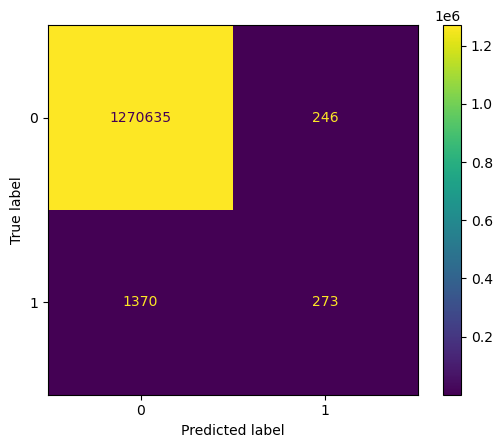

In [404]:
c_model_eval.plot_confusion_matrix()

##### Tuned Model

In [ ]:
compute = False # 41 min to compute
smote_tuning_json = "../data/evaluation/tuning_smote.json"

if compute:
    params_grid = {
        "verbose" : [-1],
        "n_jobs" : [-1],
        "n_estimators" : [100, 1000],
        "random_state" : [seed],
        "max_depth" : [7, -1],
        "num_leaves" : [15, 31],
        "learning_rate" : [0.01, 0.005, 0.1],
        "min_child_samples" : [10, 20],
        "subsample" : [0.8, 1],
        "colsample_bytree" : [0.8, 1],
        "scale_pos_weight" : [1, 5, 30]
    }

    best = {"f1": 0}


    for idx, params in enumerate(ParameterGrid(params_grid)):
        print(idx, " out of", len(ParameterGrid(params_grid)) - 1)

        lgbm_class = LGBMClassifier(**params)

        lgbm_class.fit(x_train, y_train, eval_set=[(x_val, y_val)], callbacks = [early_stopping(stopping_rounds=50)])

        y_pred = lgbm_class.predict(x_val)

        f1_curr = skm.f1_score(y_val, y_pred, zero_division=0)

        if f1_curr > best["f1"]:
            best.update(params)
            best.update({"f1": f1_curr})

    with open(smote_tuning_json, "w") as file:
        json.dump(best, file, indent = 4)

else:
    with open(smote_tuning_json, "r") as file:
        best = json.load(file)

In [412]:
best

{'f1': 0.27714285714285714,
 'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_samples': 10,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 15,
 'random_state': 11,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'verbose': -1}

In [413]:
best_params = best.copy()
best_params.pop("f1")
best_params

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_samples': 10,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 15,
 'random_state': 11,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'verbose': -1}

In [408]:
lgbm_class = LGBMClassifier(**best_params)

c_model_eval = ClassicModelsEvaluation(
    x_train = x_train,
    y_train = y_train,
    x_val = x_val, 
    y_val = y_val,
    df_eval = df_eval_tuning,
    imbalance = imbalance,
    outliers = outliers,
    normalize = normalize,
    model = lgbm_class,
    model_name = "lgbm_tuned",
    compute_cm = True
)

In [409]:
df_eval_tuning

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,z_score,lgbm_baseline,train,0.998862,0.160550,0.792955,0.267033
1,none,none,z_score,lgbm_baseline,validation,0.998835,0.156421,0.725989,0.257386
2,none,none,z_score,lgbm_tuned,train,0.998847,0.162985,0.742472,0.267294
3,none,none,z_score,lgbm_tuned,validation,0.998809,0.116859,0.747082,0.202105
4,none,smote,z_score,lgbm_baseline,train,0.995328,0.547999,0.965041,0.699045
5,none,smote,z_score,lgbm_baseline,validation,0.998730,0.166159,0.526012,0.252544
6,none,smote,z_score,lgbm_tuned,train,0.995367,0.538602,0.987958,0.697144
7,none,smote,z_score,lgbm_tuned,validation,0.996357,0.170420,0.078807,0.107775


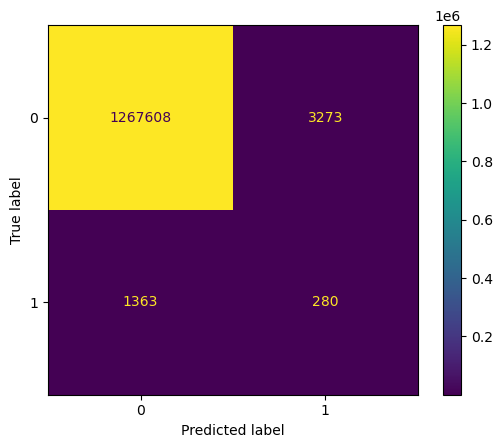

In [410]:
c_model_eval.plot_confusion_matrix()

#### Evaluating results

In [414]:
df_eval_tuning

,normalization,imbalance,outliers,model,dataset,accuracy,recall,precision,f1_score
0,none,none,z_score,lgbm_baseline,train,0.998862,0.160550,0.792955,0.267033
1,none,none,z_score,lgbm_baseline,validation,0.998835,0.156421,0.725989,0.257386
2,none,none,z_score,lgbm_tuned,train,0.998847,0.162985,0.742472,0.267294
3,none,none,z_score,lgbm_tuned,validation,0.998809,0.116859,0.747082,0.202105
4,none,smote,z_score,lgbm_baseline,train,0.995328,0.547999,0.965041,0.699045
5,none,smote,z_score,lgbm_baseline,validation,0.998730,0.166159,0.526012,0.252544
6,none,smote,z_score,lgbm_tuned,train,0.995367,0.538602,0.987958,0.697144
7,none,smote,z_score,lgbm_tuned,validation,0.996357,0.170420,0.078807,0.107775


### Threshold optimization